# AUTOENCODERS

Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np  #provides powerful tools for numerical computations and array operations.
import matplotlib.pyplot as plt  #used for creating various plots and visualizations.

from tensorflow.keras import layers, models, datasets, callbacks
#layers: Provides building blocks for creating neural network architectures.
#models: Allows you to construct and manage neural network models.
#datasets: Offers pre-built datasets for common machine learning tasks.
#callbacks: Provides functions that can be called at specific points during model training or evaluation.

import tensorflow.keras.backend as K #Imports the Keras backend, which contains low-level operations and functions used within the Keras framework.

In [2]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()  #It takes one element from the dataset and converts it into a single-element tuple.
    if isinstance(batch, tuple):   #If the batch is a tuple (containing multiple elements), it extracts the first element.
        batch = batch[0]
    return batch.numpy()    #It converts the batch data into a NumPy array and returns it.


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):

    #Displays n random images from each one of the supplied arrays.

    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [3]:
IMAGE_SIZE = 32        # all images are expected to be 32x32 pixels.
CHANNELS = 1           #This indicates the number of color channels in the images. Since the value is 1, we can infer that the images are grayscale.
BATCH_SIZE = 100       #This defines the number of images that will be processed together during each training step.
BUFFER_SIZE = 1000     #This is used for shuffling the dataset.
VALIDATION_SPLIT = 0.2 #20% of the data will be set aside to evaluate the model's performance on unseen data and avoid overfitting.
EMBEDDING_DIM = 2      #the model will be trained for 3 epochs
EPOCHS = 3

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0          #It converts the pixel values from integers (0-255) to floating-point numbers between 0.0 and 1.0. This is essential for neural networks as they typically work better with normalized inputs.
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0) # amount of padding to be applied to each dimension of the array. In this case, it's a 3-tuple, where each tuple corresponds to one dimension (channel, height, width, respectively).
    imgs = np.expand_dims(imgs, -1)
    return imgs

'''
(0, 0): No padding is added along the first dimension (batch size). The 0 on both sides means no additional rows are added at the beginning or end of the batch.
(2, 2): Padding of 2 pixels is added along the second dimension (height). This means 2 rows of zeros are added both at the top and bottom of each image.
(2, 2): Padding of 2 pixels is added along the third dimension (width). This means 2 columns of zeros are added both on the left and right of each image.
'''

x_train = preprocess(x_train) #The preprocess function is applied to the training images (x_train), and the results are stored back into x_train.
x_test = preprocess(x_test)  # the function is applied to the testing images (x_test), and the results are stored in x_test.

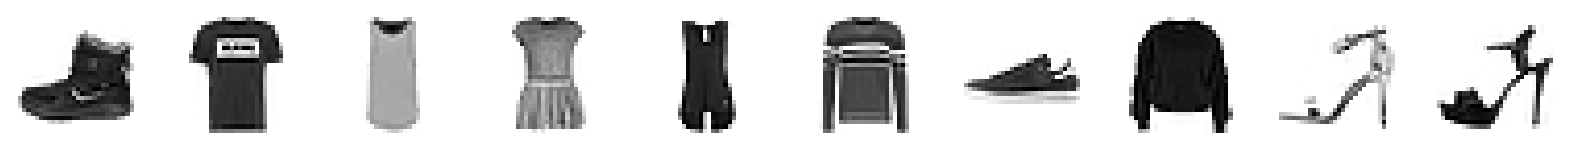

In [6]:
# Show some items of clothing from the training set
display(x_train)

In [7]:
# Encoder
# In an autoencoder, the encoder’s job is to take the input image and map it to an
# embedding vector in the latent space.

encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(           #Applies the first convolutional layer with 32 filters, a 3x3 kernel size, and a stride of 2 (downsampling).
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)        #Applies the second convolutional layer with 64 filters, similar settings as above.
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)       #Applies the third convolutional layer with 128 filters, again with similar settings.
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!            #Flattens the 3D output from the convolutional layers into a 1D vector, preparing it for the dense layer.

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [8]:
# Decoder
# The decoder is a mirror image of the encoder—instead of convolutional layers,
# we use convolutional transpose layers

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)       #Applies a dense layer with a number of units equal to the product of the saved shape
x = layers.Reshape(shape_before_flattening)(x)                          #Reshapes the output from the previous layer back to the 3D tensor shape corresponding to the pre-flattened layer in the encoder.

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

In [9]:
# Joining the Encoder to the Decoder

# To train the encoder and decoder simultaneously, we need to define a model that will
# represent the flow of an image through the encoder and back out through the decoder.

autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

In [10]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")             #Adam is a popular adaptive learning rate optimization algorithm that efficiently updates model parameters based on the gradients calculated during loss evaluation.
#This specifies the loss function used to measure the difference between the reconstructed image (model output) and the original image (ground truth)

In [11]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [12]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - 256s 422ms/step - loss: 0.3044 - val_loss: 0.2620
Epoch 2/3
600/600 [==============================] - 219s 365ms/step - loss: 0.2580 - val_loss: 0.2572
Epoch 3/3
600/600 [==============================] - 239s 398ms/step - loss: 0.2541 - val_loss: 0.2548


In [13]:
# Save the final models
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

In [14]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 6s 35ms/step
Example real clothing items


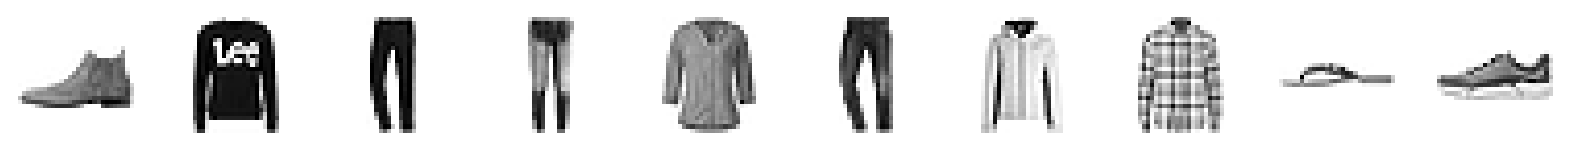

Reconstructions


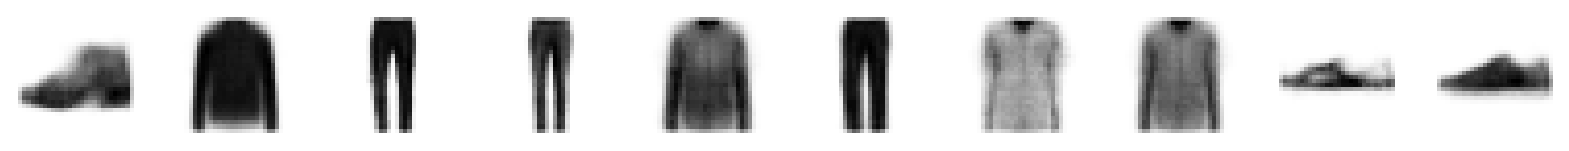

In [15]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

In [16]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 [==============================] - 1s 7ms/step


In [17]:
# Some examples of the embeddings
print(embeddings[:10])

[[ -6.109976    -5.0213265 ]
 [  0.8397828   -1.4553043 ]
 [ 16.246693     0.05254762]
 [ 18.169403    -4.727921  ]
 [  0.9166612   -3.8800492 ]
 [  9.353839    -0.64781356]
 [  2.244065    -6.7907333 ]
 [  1.4183158   -4.7683835 ]
 [ -5.1447444  -13.225336  ]
 [ -5.306459    -9.16314   ]]


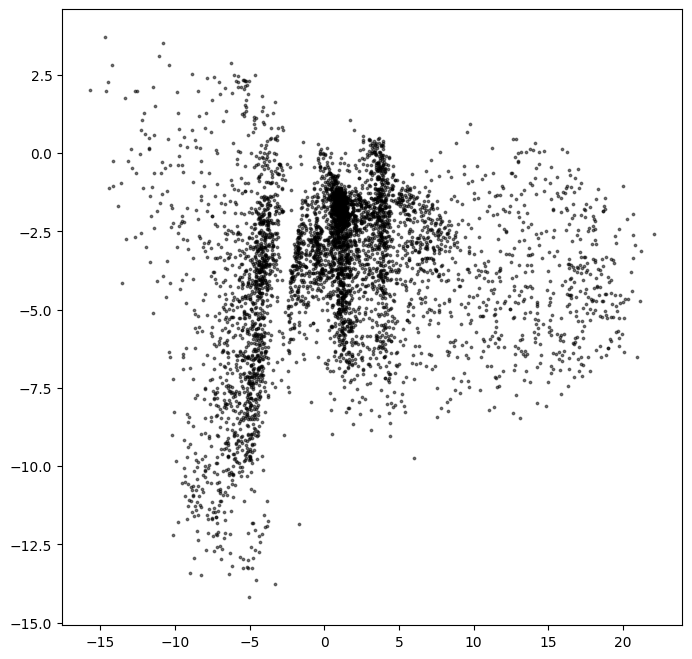

In [18]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

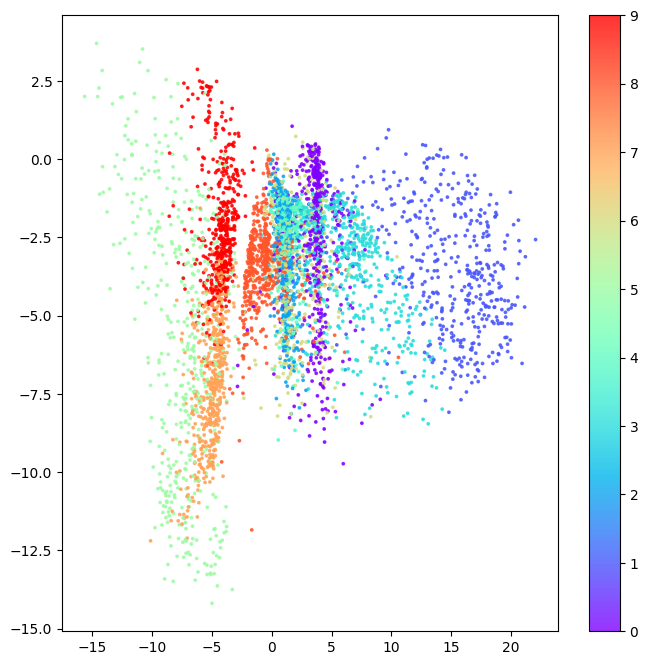

'\nID Clothing label\n0 T-shirt/top\n1 Trouser\n2 Pullover\n3 Dress\n4 Coat\n5 Sandal\n6 Shirt\n7 Sneaker\n8 Bag\n9 Ankle boot\n\n'

In [19]:
# Colour the embeddings by their label
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

'''
ID Clothing label
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

'''

In [20]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [21]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 188ms/step


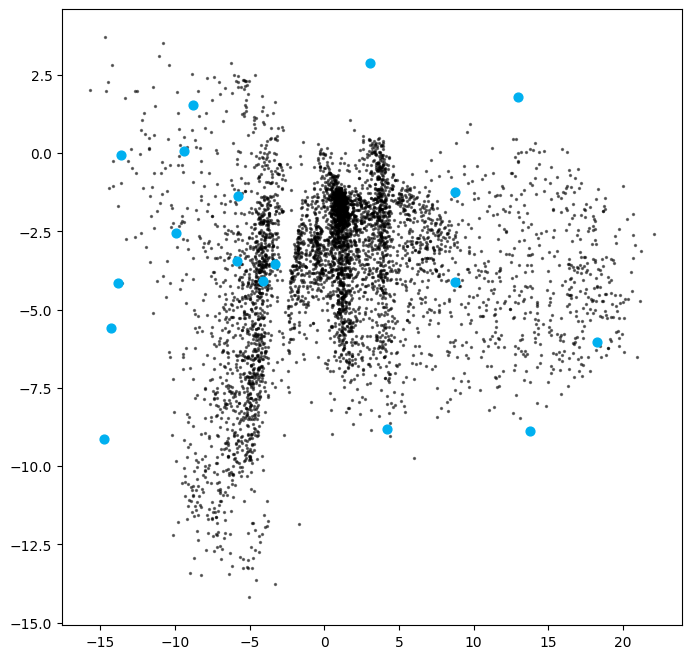

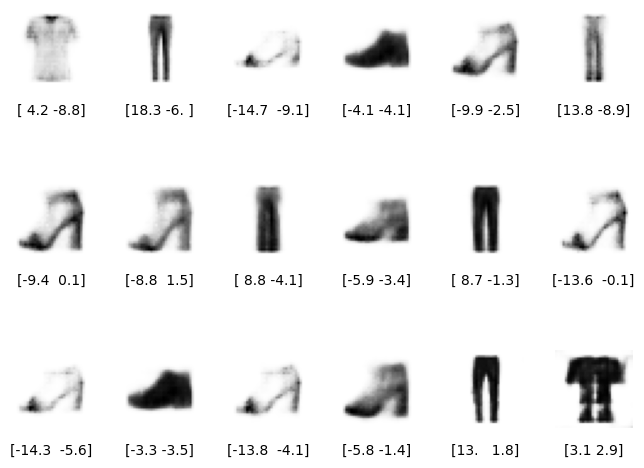

In [22]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 29ms/step


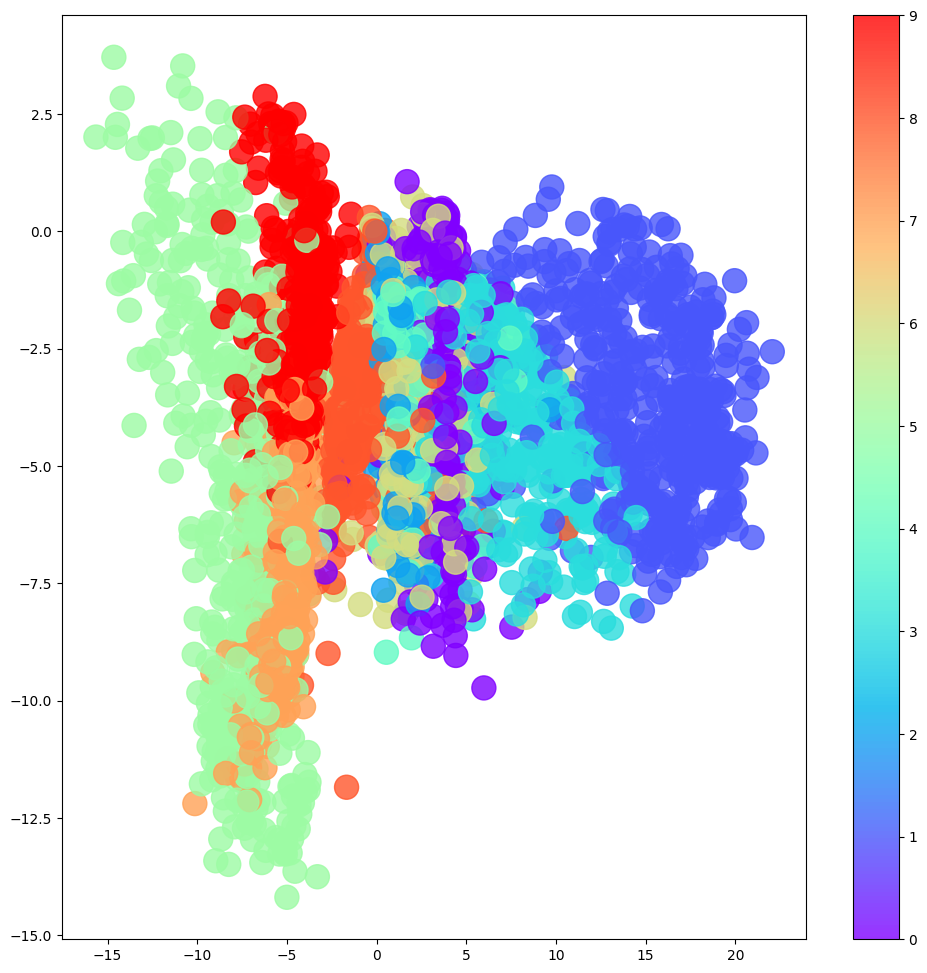

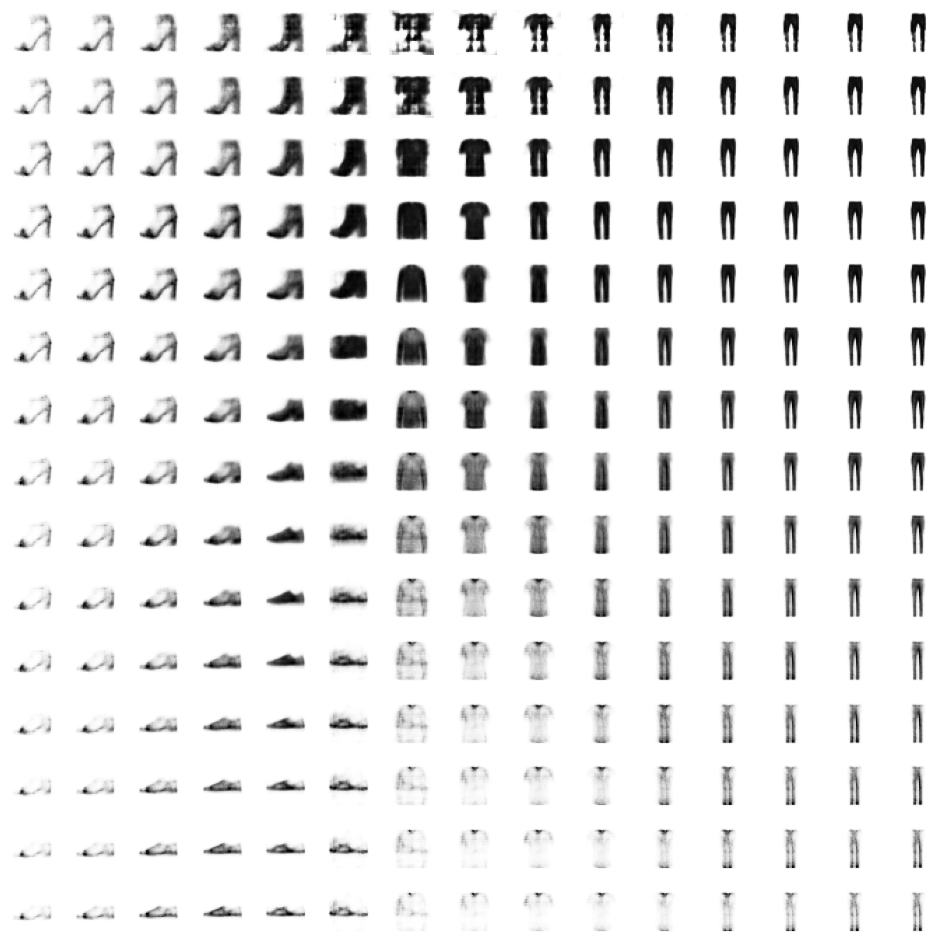

In [23]:
# Colour the embeddings by their label

figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")